# Prueba y Error

Para modificar ese comportamiento y llevarlo a un comportamiento deseado se suele retocar las ganancias mediante pruebas en LC siguiendo estas reglas:

	- Aumentar la ganancia propocional incrementa las oscilaciones.
    - El error decae más rápidamente si se disminuye el tiempo de integración.
	- Disminuir el tiempo de integración disminuye la estabilidad (aumentan las oscilaciones).
	- Aumentar el tiempo derivativo mejora la estabilidad.
	

In [78]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt

# Define the system transfer function
R1 = 10e3
C1 = 1e-6
R2 = 15e3
C2 = 1e-6
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)
print(sys)

# Define the PID controller transfer function
# Kp = 10
# Ki = 200
# Kd = .2
K  = 2
Ti = 0.01
Td = 0.1
# pid = cnt.tf([Kd, Kp, Ki], [1, 0])
pid = cnt.tf([K*Td, K, K/Ti], [1, 0])
# pid1 = cnt.tf([0, 10, 0], [1, 0])
# pid2 = cnt.tf([0, 2, 0], [1, 0])

print(pid)



<TransferFunction>: sys[245]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            1
-------------------------
0.00015 s^2 + 0.035 s + 1

<TransferFunction>: sys[246]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.2 s^2 + 2 s + 200
-------------------
         s



1.0793069569890785


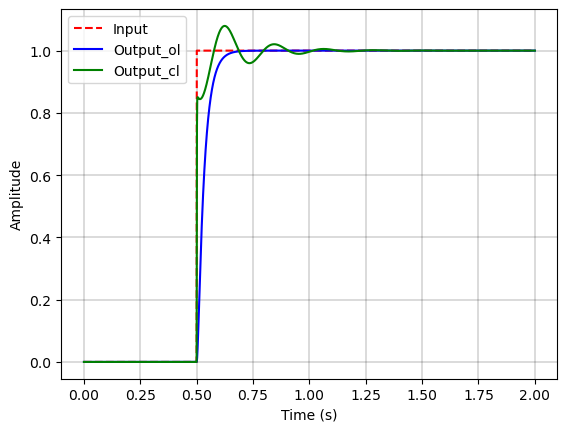

In [79]:
# Define the simulation time and input signal
t = np.linspace(0, 2, 5000)
u = np.append(np.zeros(int(len(t)/4)), np.ones(int(len(t)*3/4)))

# Simulate the closed-loop response
cl_sys  = cnt.feedback(sys*pid, 1)
# y, t = cntm.step(sys, t, 0)

# cl_sys1  = cnt.feedback(sys*pid1, 1)
# cl_sys2  = cnt.feedback(sys*pid2, 1)

t, y_ol = cnt.forced_response(sys, t, u)
t, y_cl = cnt.forced_response(cl_sys, t, u)


print(max(y_cl))

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Output_ol')
plt.plot(t, y_cl, 'g-', label='Output_cl')
# plt.plot(t, y_cl2, 'k-', label='Output_cl2')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

In [80]:
# Calcular tiempo de subida
def tiempo_de_subida(t, y):
    y_final = y[-1]
    y_10 = 0.1 * y_final
    y_90 = 0.9 * y_final

    t_10 = next(t[i] for i in range(len(y)) if y[i] >= y_10)
    t_90 = next(t[i] for i in range(len(y)) if y[i] >= y_90)

    return t_90 - t_10

# Calcular el tiempo de subida
tr = tiempo_de_subida(t, y_ol) * 1000
print(f"Tiempo de subida lazo abierto: {tr:.2f}ms")

tr = tiempo_de_subida(t, y_cl) * 1000
print(f"Tiempo de subida lazo cerrado: {tr:.2f}ms")



Tiempo de subida lazo abierto: 67.21ms
Tiempo de subida lazo cerrado: 46.41ms


# Ziegler-Nichols

## Método 1: Respuesta al escalón

El método busca aproximar la respuesta al escalón por una recta tangente al cambio de concavidad en la respuesta. A partir de esa aproximación se encuentran los parámetros.

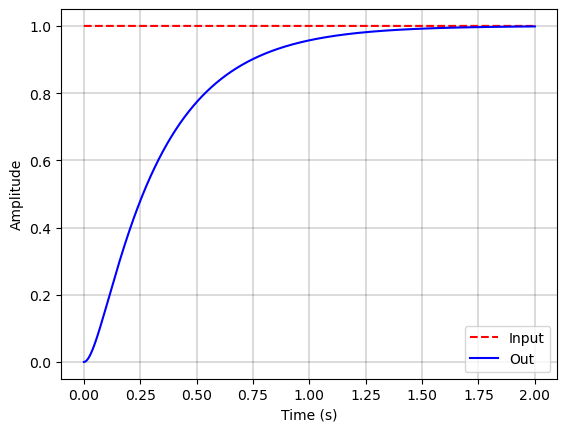

In [81]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt
# %matplotlib notebook
# Define the system transfer function
R1 = 10e3
C1 = 10e-6
R2 = 15e3
C2 = 10e-6
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)

# Define the simulation time and input signal
t = np.linspace(0, 2, 5000)
u = np.ones(len(t))

t, y_ol = cnt.forced_response(sys, t, u)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

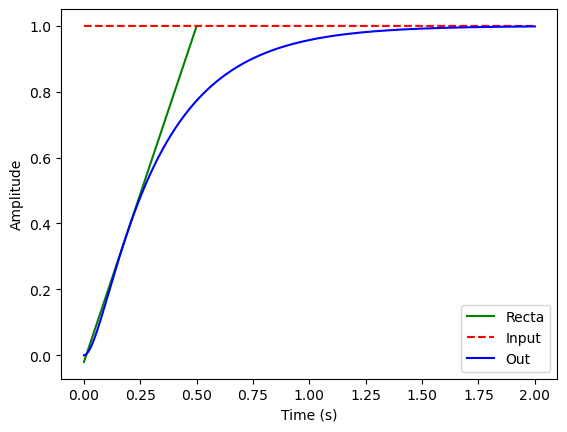

In [82]:
x1 = 0.01
x2 = 0.50
y2 = 1
y1 = 0

# Ecuación de la recta
t1 = np.linspace(0, x2, 5000)
y_r = ((y2-y1)/(x2-x1))*(t1-x1)+y1

plt.plot(t1, y_r, 'g-', label='Recta')
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()


0.588 0.08 0.01


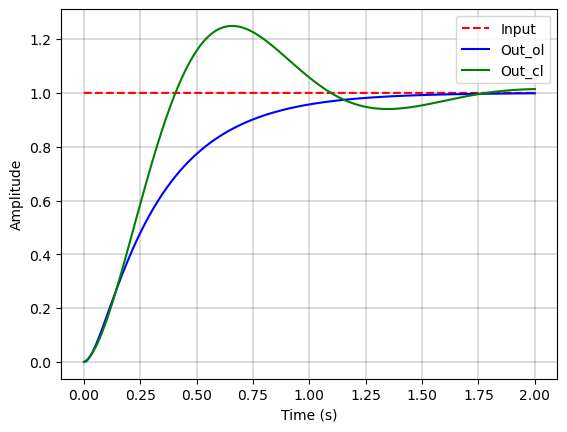

In [83]:
# Ziegler-Nichols Parameters
L = x1
T = x2-x1
# A = B = 1

# PID con Z-N
K  = 1.2*T/L * 0.01
Ti = 2*L*4
Td = 0.5*L*2

print(K,Ti,Td)

pid = cnt.tf([K*Td, K, K/Ti], [1, 0])

cl_sys  = cnt.feedback(sys*pid, 1)
t, y_cl = cnt.forced_response(cl_sys, t, u)

# %matplotlib notebook

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, u, 'r--', label='Input')
plt.plot(t, y_ol, 'b-', label='Out_ol')
plt.plot(t, y_cl, 'g-', label='Out_cl')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

In [84]:
# Verificación del Quarter Decay
print(max(y_cl)-1)
print((max(y_cl)-1)/4)


0.24891872390741687
0.06222968097685422


## Método 2: Ganancia crítica

En este método se busca llevar al sistema a funcionar en un punto de oscilaciones sostenidas al aumentar la ganancia en lazo cerrado.

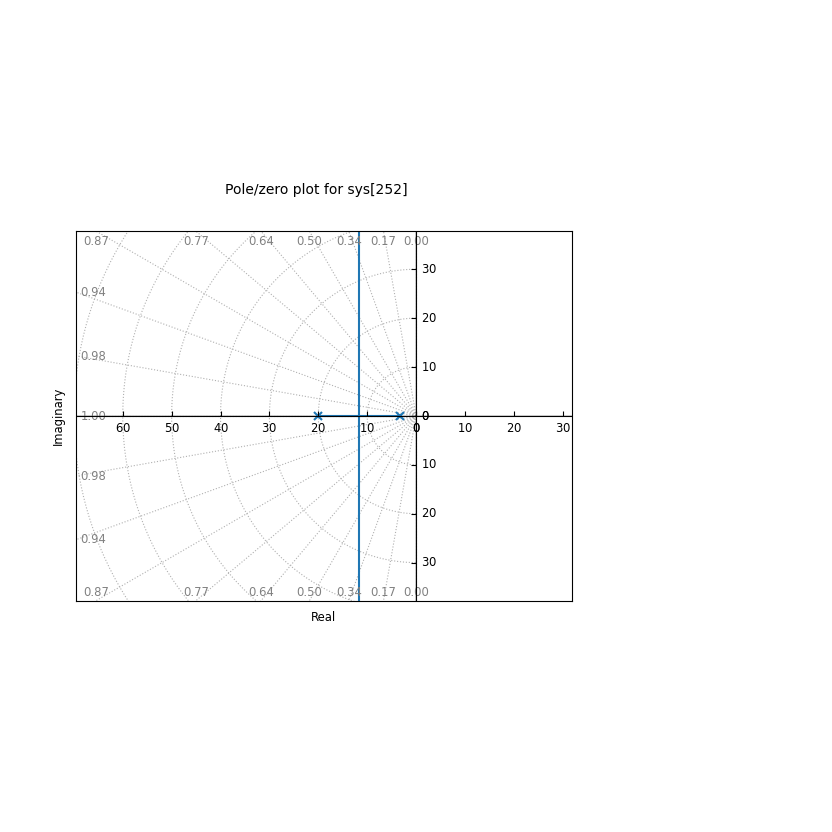

In [85]:
# Sistema en LC con ganancia
%matplotlib inline
g,p = cntm.rlocus(sys)

# Es necesario que los polos del sistema puedan ir hacia el eje imaginario para poder lograr las oscilaciones sostenidas.

# Ubicando Polos y Ceros

Se propone una forma de encontrar las ganancias del PID en función de las especificaciones de diseño

Text(0, 0.5, 'Amplitude')

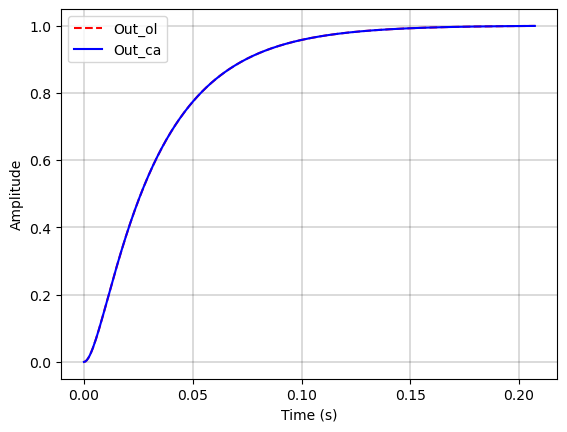

In [86]:
import numpy as np
import control as cnt
import control.matlab  as cntm
import matplotlib.pyplot as plt
import math as mt

# Define the system transfer function
R1 = 10e3
C1 = 1e-6
R2 = 15e3
C2 = 1e-6
num = [1]
den = [(R1*C1*R2*C2), (R1*C1+R1*C2+R2*C2), 1]
sys = cnt.tf(num, den)

num1 = [1/(R1*C1*R2*C2)]
den1 = [1,(R1*C1+R1*C2+R2*C2)/(R1*C1*R2*C2), 1/(R1*C1*R2*C2)]
sys1 = cnt.tf(num1, den1)

y, t = cntm.step(sys1)

p1,p2 = cnt.poles(sys1)
p1,p2
tau1 = -1/p1.real
tau2 = -1/p2.real

s = cnt.tf('s')
sys2 = (tau1*tau2/(R1*C1*R2*C2))/((s*tau1+1)*(s*tau2+1))

y_ca, t = cntm.step(sys2, t)


plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, y, 'r--', label='Out_ol')
plt.plot(t, y_ca, 'b-', label='Out_ca')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


In [87]:
# Parámetros del sistema en LA
tau1 = -1/p1.real
tau2 = -1/p2.real
ks = tau1*tau2/(R1*C1*R2*C2)
tr = 0.445 - 0.018

# Parámetros del sistema deseado en LC
trd     = 0.7*tr
Mp      = 8/100
# print(trd, Mp)
psi     = mt.sqrt(mt.log(Mp)**2/(mt.pi**2+mt.log(Mp)**2)) # Tiene que ser mayor o igual a ese valor
print(psi)
# Aumentar el psi significa que el sistema en lazo cerrado va a estar cada vez más amortiguado
psi     = psi                                             # Para que el cálculo tenga sentido psi<1 (sub-amortiguado)
phi     = mt.acos(psi)
omega_0 = trd/(mt.exp(phi/mt.tan(phi)))                   # Tiene que ser mayor o igual a ese valor
print(omega_0)
# Aumentar omega indica que el sistema va a tender a tener oscilaciones más rápidas
omega_0 = omega_0 + 6

# Calculo las raices del polinomio de lazo cerrado para saber qué sería un polo "alejado"
p1_lc,p2_lc = np.roots([1,2*psi*omega_0,omega_0**2])

# En función de los polos anteriores se elije el polo restante una decada más lejos
alpha   = 10*max(-p1_lc.real,-p2_lc.real)      
print(psi,phi,omega_0,alpha)

K  = (tau1*tau2*omega_0**2*(1+2*alpha*psi)-1)/ks
Ti = (tau1*tau2*omega_0**2*(1+2*alpha*psi)-1)/(tau1*tau2*alpha*omega_0**3)
Td = (tau1*tau2*omega_0*(alpha+2*psi)-tau1-tau2)/(tau1*tau2*omega_0**2*(1+2*alpha*psi)-1)

# Verificar que todas las ganancias del controlador den positivas (sintetiza un mejor controlador)
print('Ganancias del PID:',K,Ti,Td)
# Td podría ser negativo, pero podría generar algunas complicaciones de implementación


0.6265771868559205
0.14571492184239113
0.6265771868559205 0.8936427395335057 6.145714921842391 38.507647669464575
Ganancias del PID: -0.7209413682290264 -0.5377054828214027 -0.002293921858358716


ValueError: x and y must have same first dimension, but have shapes (5000,) and (302,)

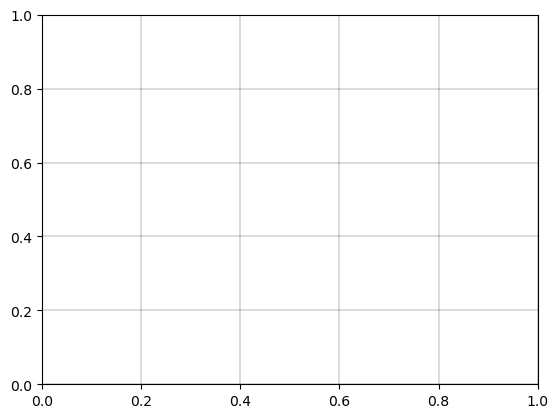

In [88]:
# %matplotlib inline
# Define time
t = np.linspace(0, 2, 5000)

pid = cnt.tf([K*Td, K, K/Ti], [1, 0])

cl_sys  = cnt.feedback(sys*pid, 1)
y_cl, t = cntm.step(cl_sys, t)

# Plot the results
plt.grid(color='k', linestyle='-', linewidth=0.2)
plt.plot(t, y, 'r--', label='Out_ol')
plt.plot(t, y_cl, 'b-', label='Out_cl')
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()

In [ ]:
# Define a function to calculate the rise time
def calculate_rise_time(signal, time,ref_value=1):
    # Find the index where the signal first crosses the start threshold
    start_index = np.argmax(signal >= 0.1*ref_value)
    
    # Find the index where the signal crosses the end threshold
    end_index = np.argmax(signal >= 0.9*ref_value)
    
    # Calculate the rise time as the difference between the two indices, multiplied by the time step
    rise_time = time[end_index] - time[start_index]
    
    return rise_time

In [ ]:
rt = calculate_rise_time(y,t)
print('Tiempo de subida en LA:',rt)
print('Tiempo de subida deseado:',0.7*rt)

Tiempo de subida en LA: 0.427
Tiempo de subida deseado: 0.2989


In [ ]:
rt_cl = calculate_rise_time(y_cl,t)
print(rt_cl,max(y_cl))

0.1704340868173635 1.1823566780299066
